<a id="top"></a>

# Comparing Stellar Spectral Types with JWST Data

***

# Learning Goals

By the end of this tutorial, you will:

- Be able to extract data for multiple targets that meet `SpectralDB` search criteria.
- Become familiar with cross-referencing outputs with `SpectralDB` against `astroquery` catalogs.
- Compare the strength of spectral features in G and K stars by eye.

# Introduction
With the new (as of the creation of this notebook) JWST observations rapidly being acquired, accessing and making sense of the new data is crucial for many observational astronomers. Checking that our astronomical intuition holds with new datasets is a helpful way to make sure that we understand the properties of these datasets.


One concrete, applicable idea from stellar astronomy is that spectral features should vary as a function of stellar type. In particular, [stellar spectral classification](https://lweb.cfa.harvard.edu/~pberlind/atlas/htmls/note.html#:~:text=Each%20spectral%20type%20is%20divided,%22color%22%20and%20surface%20brightness.) holds that as stars get cooler, they will have stronger molecular spectral features. This is because at cooler temperatures, molecules are less readily broken apart by thermal motions. Because the abundance of molecules is higher in cooler stars, these molecules will absorb more radiation, creating deeper absorption lines.  

In this tutorial, we will leverage the unique capabilities of `SpectralDB`, a MAST tool, to search directly on wavelength, querying across observations to compare the spectra of different stellar types. Specifically, we will compare the spectrum of a G star to a cooler K star, identifying the stronger molecular absorption expected in the K star.

For more information on using Specviz and SpectralDB, see the notebook [link previously written SpectralDB notebook].

The workflow for this notebook consists of:

- [Collating targets](#Collating-targets)
- [Downloading spectra](#Downloading-spectra)
- [Plotting spectra](#Plotting-spectra)

# Imports

- *matplotlib* to visualize the downloaded JWST data.
- *sys* to report our Python version.
- *requests* to interact with the SpectralDB API.
- *numpy* to rework the downloaded JWST data.
- *warnings* to limit the number of warnings printed.
- *astroquery* to cross-reference our stars.

In [1]:
import matplotlib.pyplot as plt
import requests
import sys
import numpy as np
import warnings

from astroquery.simbad import Simbad

## Collating targets

Let's first submit a request via the `SpectralDB` API. As shown in the [SpectralDB documentation](https://mast.stsci.edu/spectra/docs/), these requests can be made over flux and wavelength. There are a number of molecular features blueward of 2 microns, so let's set our wavelength range from 0 to 2 microns.

In [2]:
wav_range = '0,2'

As demonstrated in [link other notebook], these conditions will be passed to the `SpectralDB` request as strings. Ranges are represented as comma-separated values, as above.

To make some minimum quality cut on our observations (and reduce the time to query our observations), we'll also enforce that our observations have a minimum of 1 Jansky.

In [3]:
min_flux = '1'

We can now submit our request, starting with the `base_url` upon which `SpectralDB` requests are constructed:

In [4]:
base_url = 'https://mast.stsci.edu/spectra/api/v0.1/search'

Now we create our dictionary of conditions. Note that the syntax for requesting a quantity above some minimum value in `SpectralDB` is `[quantity].gt: min_value` (where gt stands for "greater than").

In [5]:
conditions = {'flux.gt': min_flux, 'wavelength': wav_range}

With the `conditions` and `base_url` set, we can submit and read in our request.

In [6]:
# submit the request
response = requests.post(base_url, json={'conditions': conditions,
                             'columns': ['targetName']})

# turn the response into a readable dictionary
response_data = response.json()

`response_data` is now a Python `dict` that we can parse to access the data we'd like. To get a sense for the data, let's take a look at the first entry of the value of the `results` key.

In [7]:
response_data['results'][0]

{'fileName': 'jw01120-o005_t002_nirspec_prism-clear_x1d.fits',
 'x': 0,
 'y': None,
 'wavelength': 0.5984808741858381,
 'flux': 2659528056.691551,
 'targetName': 'HWK-I 74230'}

The response of the request returned the fileneame of the data, the average wavelength of the observation, the average flux of the observation, and the name of the target name observed. For 2D data, `x` and `y` are used for plotting, but they are not relevant to the 1D spectra that we consider here.

Next, we can parse through these results to construct a list of unique target names. We'll ignore blank target names.

In [8]:
names = []
for d in response_data['results']:
    name = d['targetName']
    if name != '':
        names += [name]
    
print(np.unique(names))

['(2002 XV93)' '10 Hygiea' '175113 (2004 PF115)' '2 Pallas'
 '230965 (2004 XA192)' '2MASS J12560183-1257276' '2MASS J15395077-3404566'
 '2MASS J16194609+5534178' '2MASS J17430448+6655015'
 '2MASS J17540383-2810466' '307982 (2004 PG115)' '52872 Okyrhoe'
 '624 Hektor' 'BD+04 3653' 'ENCELADUS' 'F2M1106' 'GANYMEDE' 'GCRV 21765'
 'GSPC P330-E' 'HWK-I 74230' 'IRAS 05248-7007' 'JUPITER' 'Kopff'
 'NGC 2070 S7B' 'NGC 7469' 'NIRISS Focus Field' 'ORIBAR-NIRSPEC' 'Read'
 'SDSSJ1652+1728' 'SDSSJ1723+3411' 'SMACS J0723.3-7327' 'SMP-LMC-58'
 'TITAN' 'TYC 3986-834-1' 'TYC 4433-1800-1' 'VV114' 'WD1657+343' 'XID2028']


These targets span a number of different catalogs. We can use `astroquery`'s functionality to check the spectral type of each object, if it is a star.

First, we instantiate a [`Simbad` object](https://astroquery.readthedocs.io/en/latest/simbad/simbad.html) and make sure that the spectral type is reported in its queries.

In [9]:
customSimbad = Simbad()
customSimbad.add_votable_fields('sptype')

Next, we iterate through the objects and report out their stellar types. Because we've added the `sptype` field to our request, the `query_object` method that we will use will throw a warning for objects that are not stars. Therefore, we will disable warnings for while we iterate through the objects.

In [10]:
with warnings.catch_warnings():
    # disable warnings
    warnings.simplefilter("ignore")
    for name in np.unique(names):

        # query the object
        result = customSimbad.query_object(name)

        # ignore this object if no result is returned
        if not result:
            continue

        spectral_type = result['SP_TYPE'][0]

        # ignore this object if it has no spectral type
        if spectral_type == '':
            continue

        print(name, spectral_type)

2MASS J12560183-1257276 L8.0
2MASS J15395077-3404566 M0III
2MASS J16194609+5534178 G0-5
2MASS J17430448+6655015 A5V
2MASS J17540383-2810466 M4.5III
BD+04 3653 K5III
GCRV 21765 A0
GSPC P330-E G2V
TYC 3986-834-1 K0III
TYC 4433-1800-1 A3V
WD1657+343 DA.9


It seems that our sample of targets includes a K star (BD+04 3653) and a G star (GSPC P330-E). Their spectra should be different; K dwarfs, for instance, should have more pronounced molecular features than G dwarfs.

## Downloading spectra

Let's start by examining the G star in our `response_data`.

In [11]:
# access target files for G star

targetname = 'GSPC P330-E'

targetfiles = []

for d in response_data['results']:
    if d['targetName'] == targetname:
        targetfiles += [d['fileName']]


In [12]:
np.unique(targetfiles)

array(['jw01538-o062_t002_nirspec_g140h-f100lp_x1d.fits',
       'jw01538-o062_t002_nirspec_g140m-f100lp_x1d.fits',
       'jw01538-o062_t002_nirspec_g235h-f170lp_x1d.fits',
       'jw01538-o062_t002_nirspec_g235m-f170lp_x1d.fits'], dtype='<U47')

There are multiple files that we can download. Let's pick the third file, as it observed with the same grating as the K star observation (G235H).

Our HTTP request requires a header, which can be constructed as a `dict`.

In [13]:
# retrieve our system's Python version for the request. 
version = ".".join(map(str, sys.version_info[:3]))
# create HTTP Header Variables
headers = {"Content-type": "application/x-www-form-urlencoded",
           "Accept": "text/plain",
           "User-agent":"python-requests/"+version}

Next, we make our request with the target file.

In [14]:
# download first target file
targetfile = np.unique(targetfiles)[2]

request_url=f'https://mast.stsci.edu/spectra/api/v0.1/retrieve?filename={targetfile}'    

# perform the HTTP request
spectrum_response = requests.get(request_url, headers=headers)

spectrum_object = spectrum_response.json()

print(spectrum_object['message'])

Successfully found data for jw01538-o062_t002_nirspec_g235h-f170lp_x1d.fits


We can now unpack our successfully downloaded spectrum.

In [15]:
# extract G star spectrum components

g_star_wav = np.array(spectrum_object['data']['wavelength'])

g_star_flux = np.array(spectrum_object['data']['flux'])
g_star_flux_err = np.array(spectrum_object['data']['fluxErr'])

Some light data-cleaning below next ensures that each individual data point has at least a SNR of 0.5.

In [16]:
# remove noisy G star spectral data
g_star_flux_masked = g_star_flux[g_star_flux_err/g_star_flux < 2]
g_star_flux_err_masked = g_star_flux_err[g_star_flux_err/g_star_flux < 2]
g_star_wav_masked = g_star_wav[g_star_flux_err/g_star_flux < 2]

As a last step for this star, we properly transform its error into log space.

In [17]:
# transform G star spectral data into log space
g_star_log_err = (1/np.log(10)) * g_star_flux_err_masked/g_star_flux_masked

We can now repeat the above steps for the K star from our `response_data`.

In [18]:
targetname = 'BD+04 3653'

targetfiles = []

for d in response_data['results']:
    if d['targetName'] == targetname:
        targetfiles += [d['fileName']]


targetfile = np.unique(targetfiles)[0]

In [19]:
print(np.unique(targetfiles))

['jw01364-o003_t003_nirspec_g235h-f170lp_x1d.fits']


In [20]:

request_url=f'https://mast.stsci.edu/spectra/api/v0.1/retrieve?filename={targetfile}'    

# perform the HTTP request
spectrum_response = requests.get(request_url, headers=headers)

spectrum_object = spectrum_response.json()

print(spectrum_object['message'])

Successfully found data for jw01364-o003_t003_nirspec_g235h-f170lp_x1d.fits


In [21]:
# extract K star spectrum components

k_star_wav = np.array(spectrum_object['data']['wavelength'])

k_star_flux = np.array(spectrum_object['data']['flux'])
k_star_flux_err = np.array(spectrum_object['data']['fluxErr'])

# remove noisy K star spectral data
k_star_flux_masked = k_star_flux[k_star_flux_err/k_star_flux < 2]
k_star_flux_err_masked = k_star_flux_err[k_star_flux_err/k_star_flux < 2]
k_star_wav_masked = k_star_wav[k_star_flux_err/k_star_flux < 2]


# transform K star spectral data into log space
k_star_log_err = (1/np.log(10)) * k_star_flux_err_masked/k_star_flux_masked

## Plotting spectra

With all of our data downloaded and cleaned, we can finally plot the results!

/var/folders/zg/pp98nf5j52b0_pww3l0b71f40000gq/T/ipykernel_39107/917986835.py:2: RuntimeWarning: invalid value encountered in log10
  markers, caps, bars = plt.errorbar(k_star_wav_masked, np.log10(k_star_flux_masked),


Text(0, 0.5, 'Log10 Flux (Jy)')

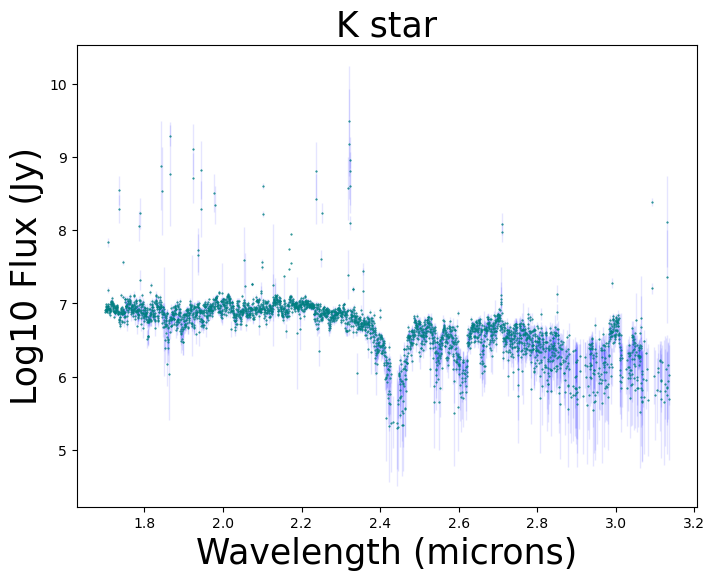

In [22]:
plt.figure(figsize=(8,6))
markers, caps, bars = plt.errorbar(k_star_wav_masked, np.log10(k_star_flux_masked), 
             yerr=k_star_log_err, 
             color='teal',
             fmt='.',
            ms=1,
            elinewidth=1,
            ecolor='blue')

[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]


plt.title('K star', fontsize=25)

plt.xlabel('Wavelength (microns)', fontsize=25)

plt.ylabel('Log10 Flux (Jy)', fontsize=25)

/var/folders/zg/pp98nf5j52b0_pww3l0b71f40000gq/T/ipykernel_39107/480626688.py:2: RuntimeWarning: invalid value encountered in log10
  markers, caps, bars = plt.errorbar(g_star_wav_masked, np.log10(g_star_flux_masked),


Text(0, 0.5, 'Log10 Flux (Jy)')

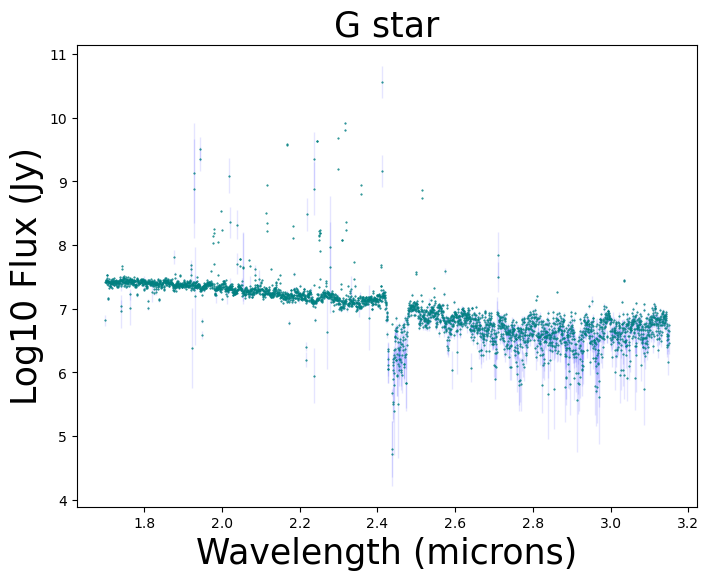

In [23]:
plt.figure(figsize=(8,6))
markers, caps, bars = plt.errorbar(g_star_wav_masked, np.log10(g_star_flux_masked), 
             yerr=(1/np.log(10)) * g_star_flux_err_masked/g_star_flux_masked, 
             color='teal',
             fmt='.',
            ms=1,
            elinewidth=1,
            ecolor='blue')

[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]

plt.title('G star', fontsize=25)

plt.xlabel('Wavelength (microns)', fontsize=25)

plt.ylabel('Log10 Flux (Jy)', fontsize=25)

Showing both spectra in the same plot will make the spectral differences more distinct.

/var/folders/zg/pp98nf5j52b0_pww3l0b71f40000gq/T/ipykernel_39107/1665948621.py:4: RuntimeWarning: invalid value encountered in log10
  markers, caps, bars = plt.errorbar(k_star_wav_masked, np.log10(k_star_flux_masked),
/var/folders/zg/pp98nf5j52b0_pww3l0b71f40000gq/T/ipykernel_39107/1665948621.py:17: RuntimeWarning: invalid value encountered in log10
  markers, caps, bars = plt.errorbar(g_star_wav_masked, np.log10(g_star_flux_masked),


Text(0, 0.5, 'Log10 Flux (Jy)')

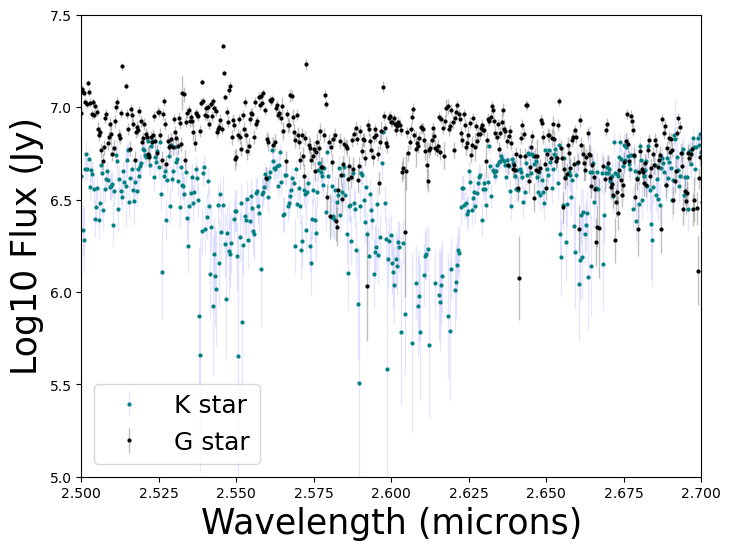

In [24]:
plt.figure(figsize=(8,6))


markers, caps, bars = plt.errorbar(k_star_wav_masked, np.log10(k_star_flux_masked), 
             yerr=(1/np.log(10)) * k_star_flux_err_masked/k_star_flux_masked, 
             color='teal',
             fmt='.',
            ms=4,
            elinewidth=1,
            ecolor='blue', label='K star')

[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]



markers, caps, bars = plt.errorbar(g_star_wav_masked, np.log10(g_star_flux_masked), 
             yerr=(1/np.log(10)) * g_star_flux_err_masked/g_star_flux_masked, 
             color='black',
             fmt='.',
            ms=4,
            elinewidth=1,
            ecolor='gray',
                                  label='G star')

[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

# plt.scatter(wav, flux)

# plt.yscale('log')
plt.ylim(5,7.5)
plt.xlim(2.5, 2.7) 

plt.legend(fontsize=18)
plt.xlabel('Wavelength (microns)', fontsize=25)

plt.ylabel('Log10 Flux (Jy)', fontsize=25)

As expected, the K star has stronger spectral features (deeper absorption lines) than the G star. While noise is defeinitely present (identified by deviations from the mean that are not coherent across multiple pixels), this noise is defeinitely low enough that spectral features (such as near 2.55 microns in the K star spectrum) can be seen by eye.

# Exercises
- Compare an A star spectrum to a G star spectrum. How do the spectral features differ? Do they differ in expected ways?
- Find observations of Jupiter's emission spectrum over a wide wavelength range (e.g., 1 to 15 micron). Some spectral features are obvious by eye; what are they?

# Additional Resources
- [Classification of stellar spectra](http://www.star.ucl.ac.uk/~pac/spectral_classification.html) 
- [JWST home page](https://webb.nasa.gov/)
- [NIRSPEC filters and gratings](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-dispersers-and-filters)

# About this Notebook

If you have questions, comments, or feedback about this notebook, please email archive@stsci.edu.

**Last updated**: 2022-09-22

# Citations
If you use `astroquery`, `matplotlib`, or `numpy` for published research, please cite the authors. Follow these links for more information about citing `astoquery`, `matplotlib`, and `numpy`:

* [Citing `astroqery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
